In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### read in files

In [3]:
fig5_data = pd.read_excel (r"Excel files\F5\Fig 5 --Iba1 and Fabp7 NB pct.xlsx")
figS5_data = pd.read_excel (r"Excel files\F5\Fig S5.1 --Iba1 and Fabp7 per image pct.xlsx")

In [4]:
fig5_data

,Unnamed: 0,ID,gender,condition,P1 name,P1 IL,P1 CL,P2 name,P2 IL,P2 CL
0,0,RC1,M,1W,Iba1 per NB (%),7.220016,4.258738,FABP7 per NB (%),56.765519,75.044386
1,1,RC1,M,1W,Iba1 per NB (%),7.085267,3.545276,FABP7 per NB (%),71.245277,70.527724
2,2,RC1,M,1W,Iba1 per NB (%),13.628166,1.296856,FABP7 per NB (%),62.542212,64.340531
3,3,RC1,M,1W,Iba1 per NB (%),13.761140,4.319121,FABP7 per NB (%),42.324188,61.626473
4,4,RC1,M,1W,Iba1 per NB (%),17.685044,4.023796,FABP7 per NB (%),59.018940,76.424943
...,...,...,...,...,...,...,...,...,...,...
91,91,RC44,F,5W,Iba1 per NB (%),1.849664,2.666730,FABP7 per NB (%),31.023182,35.498633
92,92,RC44,F,5W,Iba1 per NB (%),7.431204,0.907279,FABP7 per NB (%),29.933486,31.270150
93,93,RC44,F,5W,Iba1 per NB (%),2.497847,3.293189,FABP7 per NB (%),30.054432,21.096383
94,94,RC44,F,5W,Iba1 per NB (%),3.792244,3.417651,FABP7 per NB (%),12.015077,27.235969


In [5]:
def transform_to_longformat(df):
    import re
    
    # extract parameter and their indices ( "P1", "P2", ...)
    param_ids = sorted(set(
        re.match(r"(P\d+)", col).group(1)
        for col in df.columns
        if re.match(r"P\d+ name", col)
    ))
    
    # create il and cl dataframes
    df_il = df[["ID", "gender", "condition"]].copy()
    df_il["side"] = "IL"
    
    df_cl = df[["ID", "gender", "condition"]].copy()
    df_cl["side"] = "CL"
    
    # add names and values per parameter
    for pid in param_ids:
        name_col = f"{pid} name"
        il_col = f"{pid} IL"
        cl_col = f"{pid} CL"
        
        # get name from Px name
        param_names = df[name_col]
        df_il = df_il.copy()
        df_cl = df_cl.copy()
        
        for i in df.index:
            df_il.loc[i, param_names[i]] = df.loc[i, il_col]
            df_cl.loc[i, param_names[i]] = df.loc[i, cl_col]
    
    # add il and cl 
    df_long = pd.concat([df_il, df_cl], ignore_index=True)
    
    # generate groups based on gender, condition and side
    df_long["group"] = df_long["gender"] + "_" + df_long["condition"] + "_" + df_long["side"]
    
    return df_long

In [6]:
fig5_long = transform_to_longformat (fig5_data)
figS5_long = transform_to_longformat (figS5_data)

In [14]:
fig5_long

,ID,gender,condition,side,Iba1 per NB (%),FABP7 per NB (%),group
0,RC1,M,1W,IL,7.220016,56.765519,M_1W_IL
1,RC1,M,1W,IL,7.085267,71.245277,M_1W_IL
2,RC1,M,1W,IL,13.628166,62.542212,M_1W_IL
3,RC1,M,1W,IL,13.761140,42.324188,M_1W_IL
4,RC1,M,1W,IL,17.685044,59.018940,M_1W_IL
...,...,...,...,...,...,...,...
187,RC44,F,5W,CL,2.666730,35.498633,F_5W_CL
188,RC44,F,5W,CL,0.907279,31.270150,F_5W_CL
189,RC44,F,5W,CL,3.293189,21.096383,F_5W_CL
190,RC44,F,5W,CL,3.417651,27.235969,F_5W_CL


# Boxplots

## used in Paper:

### all conditions

In [82]:
def plot_confocal (saveto, data, param, ylabel, ylim = None):
    #print (data)
    standard_props = {"alpha":1, "linewidth":2}
    bbox_props = {**standard_props, 'facecolor': 'w', 'edgecolor':"k"}

    pal2 = ['#36ada4', '#37abb8', '#39a7d0', '#5a9ef4',
            '#a48cf4', '#d673f4', '#f561dd', '#f66ab5', 
            '#97a431', '#6cad31', '#32b166', '#34af8e',
            '#f77189', '#f77732', '#ce9032', '#b39b32']
 
    groups= [ "Pre", "M_1W_CL", "M_5W_CL", "first", "M_1W_IL", "M_5W_IL", "gap", 
                     "F_1W_CL", "F_5W_CL", "second", "F_1W_IL", "F_5W_IL", "end"]
    groups_strip= [ "M_1W_CL", "M_5W_CL", "first", "M_1W_IL", "M_5W_IL", "gap", 
                     "F_1W_CL", "F_5W_CL", "second", "F_1W_IL", "F_5W_IL", "end"]
    
    pal_lines = ["k", '#79cfd8', '#b2ef7d', #MCL1W, #MCL5W
                "k", '#37abb8', '#6cad31', #MIL1W, #MIL5W
                "k", '#ff99ff', '#fab38a', #FCL1W, #FCL5W
                "k", "#ff66ff", "#f77732", #FIL1W, #FIL5W
                "k"]
    
    fontsize = 30
    linewidth = 3
    
    plt.figure(figsize=(12,8))
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.tick_params(axis = "x", length=0)
    ax.tick_params(axis = "y", length=10, width=linewidth)
    if ylim is not None:
        ax.set_ylim (ylim)
    #plt.xlim(-0.5, 9.5)
    ax.set_xticks(range(len(groups)))
    ax.set_xticklabels(groups, fontname="Arial", fontsize=fontsize, rotation=90)
    plt.xticks(fontname="Arial", fontsize=fontsize, rotation = 90)
    plt.yticks(fontname="Arial", fontsize=fontsize)
    plt.axvline(6, c='gray', linewidth= linewidth, ls='--')
    plt.subplots_adjust(left=0.1)
        
    plt.ylabel(ylabel, fontname="Arial", fontsize=fontsize+8)

    ax.set_xticks(range(len(groups)))
    ax.set_xticklabels(groups, fontname="Arial", fontsize=fontsize, rotation=90)
    
    for i, grp in enumerate(groups):
        subdata = data[data["group"] == grp]
        if not subdata.empty:
            sns.boxplot(data=subdata, y=param, width=0.9,
                    positions=[i],
                    boxprops=dict(facecolor='white', edgecolor=pal_lines[i], linewidth=2.5),
                    whiskerprops=dict(color=pal_lines[i], linewidth=2.5),
                    capprops=dict(color=pal_lines[i], linewidth=2.5),
                    medianprops=dict(color=pal_lines[i], linewidth=2.5),
                    showcaps=True, fliersize=0)
            
    #data["group_pos"] = data["group"].map({g: i for i, g in enumerate(groups)})
    sns.stripplot(data=data, x="group", y=param, size=6, jitter=0.3,
              hue="ID", palette=pal2, edgecolor='black', linewidth=0.5,
              dodge=False, order=groups_strip, alpha=1)
    #plt.legend(loc = "upper left", ncol = 4)
    plt.legend (bbox_to_anchor =(1.15, 0.75))
    
    plt.savefig(saveto + param + '.png', bbox_inches = "tight")
    plt.show()

## Use plot 

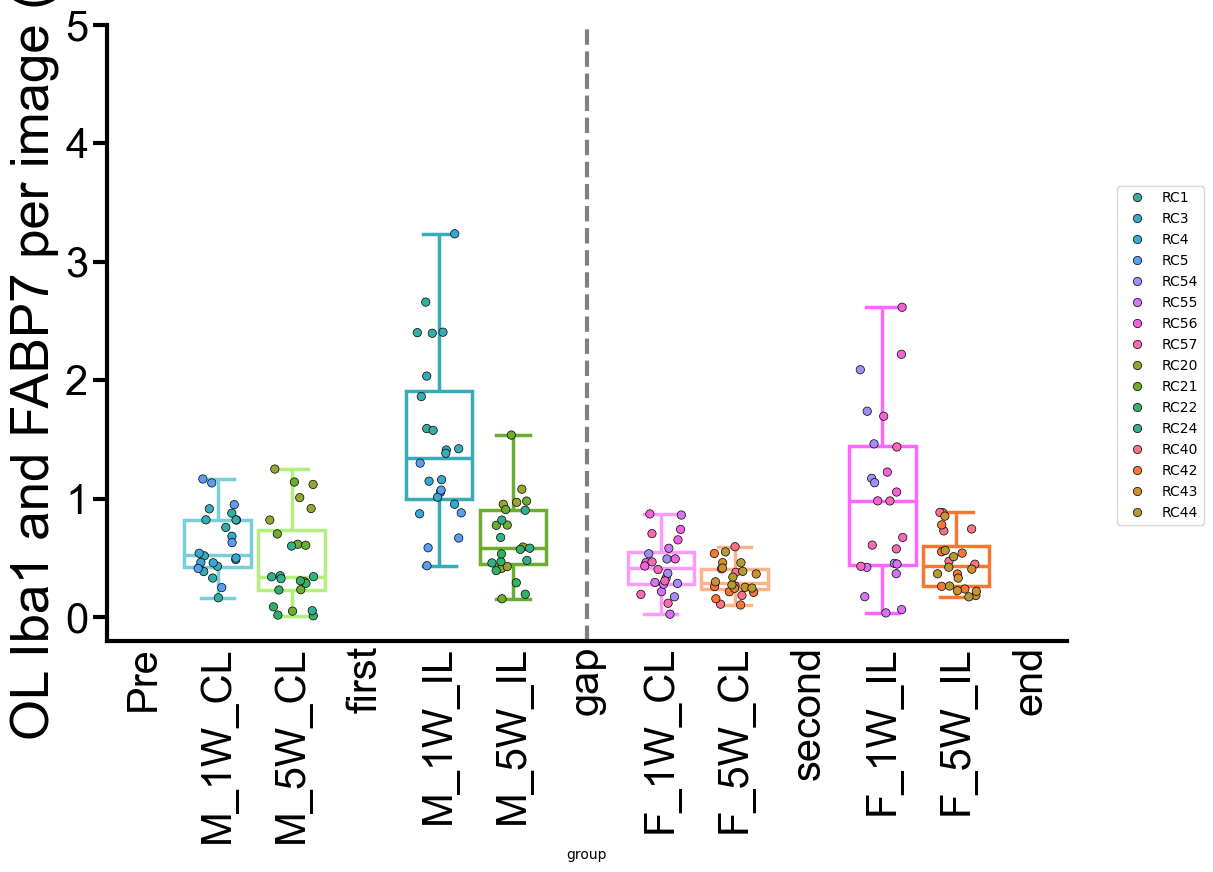

In [118]:
#Iba1 label per image (%)	FABP7 label per image (%)	OL Iba1 and FABP7 per image (%)
saveto = "plots June25/FigS7 -- F5 -- "
data = figS5_long
param = "OL Iba1 and FABP7 per image (%)"
ylabel = param
ylim = (-0.2, 5)
#ylim = None

plot_confocal (saveto, data, param, ylabel, ylim = ylim)